# Import

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from bioreactor.plotting import *
from bioreactor.utils import *
from bioreactor.ssgsea import *
from bioreactor.gsea import *
from bioreactor.annotation import *
from bioreactor.survival import *
from scipy import stats
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import Binarizer
import optuna
from optuna.integration import OptunaSearchCV
from BorutaShap import BorutaShap
import shap
from datetime import datetime
from pathlib import Path

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('white')

def calculate_and_plot_correlations(series1, series2,name1='Predicted', name2='True',
                                    verbose=True, ret=False, plot=True,title=False):   
    from sklearn import metrics
    from scipy import stats                                    
    series1, series2 = to_common_samples((series1.dropna(), series2.dropna()))
    df = pd.DataFrame({name1: series1, name2: series2})
    pearson_corr, pearson_p = stats.pearsonr(series1, series2)
    spearman_corr, spearman_p = stats.spearmanr(series1, series2)
    mse = metrics.mean_squared_error(series1, series2)
    mae = metrics.mean_absolute_error(series1, series2)
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(series1, series2)
        concordance_corr_coef = (2 * r_value * np.std(series1) * np.std(series2)) / (np.var(series1) + np.var(series2) + (np.mean(series1) - np.mean(series2))**2)
    except:
        concordance_corr_coef = 0
    text =  [f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.1e}",
          f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.1e}",
    f"MSE: {mse:.4f}; MAE: {mae:.4f}",
    f"CCC: {concordance_corr_coef:.4f}",
    f"Number of samples: {df.dropna().shape[0]}"]
    if verbose:
        print('\n'.join(text))
    if plot:
        g = sns.JointGrid(data=df, x=name1, y=name2, space=0)
        g.plot_joint(sns.scatterplot, alpha=0.6,color = 'teal')
        sns.regplot(x=name1, y=name2, data=df, ax=g.ax_joint, scatter=False, color='r')
        g.plot_marginals(sns.histplot, kde=True, color="teal")
        if title:
            text+=[title]
        textstr = '\n'.join(text)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        g.ax_joint.text(0.05, 0.95, textstr, transform=g.ax_joint.transAxes, fontsize=10,
                        verticalalignment='top', bbox=props, linespacing=1.5)
        plt.show()
        plt.close()
    if ret:
        metrics = {
        'MSE': mse,
        'MAE': mae,
        'Spearman':spearman_corr,
        'CCC':concordance_corr_coef,
        'Pearson':pearson_corr}
        return metrics
    
def plt_mean_auc_curve(ax, x_list, y_list, auc_metric_list, name='Model', color='crimson', type='roc',plot_random=True, legend_out=False):
    mean_x = np.linspace(0, 1, 100)
    ys_interp = []
    
    for x, y in zip(x_list, y_list):
        sort_idx = np.argsort(x) 
        x = np.array(x)[sort_idx]
        y = np.array(y)[sort_idx]

        y_interp = np.interp(mean_x, x, y)
        y_interp[0] = 1.0 if type=='pr' else 0.0
        y_interp[-1] = 1.0
        ys_interp.append(y_interp)

    mean_y = np.mean(ys_interp, axis=0)
    std_y = np.std(ys_interp, axis=0)
    ys_upper = np.minimum(mean_y + std_y, 1)
    ys_lower = np.maximum(mean_y - std_y, 0)
    
    std_auc = np.std(auc_metric_list)
    roc_auc = np.mean(auc_metric_list)
    
    ax.plot(mean_x, mean_y, color=color, label='%s\n(AUC = %0.2f±%0.2f)' % (name, roc_auc, std_auc), alpha=0.8)
    ax.fill_between(mean_x, ys_lower, ys_upper, color=color, alpha=.2)
    
    if type=='roc':
        x_c,y_c=[0, 1], [0, 1]
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
    elif type=='pr':
        x_c,y_c=[0, 1], [0.5, 0.5]
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
    if plot_random:
            ax.plot(x_c,y_c,'b-', alpha=0.8,label='Random Classificator')
    ax.set_xlim([-0.03, 1.03])
    ax.set_ylim([-0.03, 1.03])
    if legend_out:
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 
    else:
        ax.legend(loc='lower right')


def plt_auc_curve(ax,x,y,auc_metric, color='crimson',name='Model', type='roc',plot_random=True, legend_out=False):
    ax.plot(x, y,'-', label='%s\nROC (area = %0.2f)' % (name, auc_metric), c=color, alpha=0.8)
    if type=='roc':
        x_c,y_c=[0, 1], [0, 1]
        ax.set_ylabel('True-positive rate')
        ax.set_xlabel('False-positive rate')
    elif type=='pr':
        x_c,y_c=[0, 1], [0.5, 0.5]
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
    if plot_random:
        ax.plot(x_c,y_c,'b-', alpha=0.8,label='Random Classifier')
    ax.set_xlim([-0.03, 1.03])
    ax.set_ylim([-0.03, 1.03])
    if legend_out:
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 
    else:
        ax.legend() 


def plt_confusion_matrix(y_test_bin,y_pred_bin,thr,name=False):
        y_test_bin.name,y_pred_bin.name = 'True','Prediction'
        matrix = pd.crosstab(y_test_bin,y_pred_bin)
        matrix.index = [f"Lower than {thr:.1f}", f"Higher than {thr:.1f}"]
        matrix.columns = matrix.index
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        ax=axes[0]
        sns.heatmap(matrix, annot=True,fmt='g',
                cmap="Blues",ax=ax)
        ax.set_xlabel('Prediction')
        ax.set_ylabel('True')
        ax=axes[1]
        matrix = matrix/matrix.sum()
        sns.heatmap(matrix, annot=True,fmt='.1%',
                cmap="Blues",ax=ax) 
        ax.set_xlabel('Prediction')
        ax.set_ylabel('True')
        if name:
            fig.suptitle(name)
        plt.show()       
        plt.close()

def calculate_metrics(model, X_test, y_test,ret=False, verbose = True, thr=2, 
                      plot_curves=False, plot_confusion_matrices=False, plot_correlations=False,
                     name = 'Model', classifier = False):
    from sklearn import metrics
    from scipy import stats
    y_pred = pd.Series(data=model.predict(X_test),index=X_test.index)
    if not classifier:
        metrics_corr = calculate_and_plot_correlations(y_pred,y_test, verbose=False, ret=True,plot=plot_correlations)
        y_test_bin = hl_tls_area.reindex(y_test.index).dropna().map(lambda x:0 if 'low' in x.lower() else 1)
        y_pred_bin = pd.qcut(y_pred,q=[0,0.5,1],labels=[0,1], duplicates='drop')
        probas = y_pred
    else:
        metrics_corr= None
        y_test_bin = y_test
        y_pred_bin = y_pred
        probas = model.predict_proba(X_test)[:,1]
    y_test_bin.name,y_pred_bin.name = f"{name}_True",f"{name}_Predicted"
    fpr, tpr, _ = metrics.roc_curve(y_test_bin, probas)
    roc_auc = metrics.auc(fpr, tpr)
    f1 = metrics.f1_score(y_test_bin, y_pred_bin)
    accuracy = metrics.accuracy_score(y_test_bin, y_pred_bin)
    recall_score = metrics.recall_score(y_test_bin, y_pred_bin)
    precision_score = metrics.precision_score(y_test_bin, y_pred_bin)
    av_precision = metrics.average_precision_score(y_test_bin, y_pred_bin)
    precision, recall, _ = metrics.precision_recall_curve(y_test_bin, probas)
    pr_auc = metrics.auc(recall, precision)
    if verbose:
        if not classifier:
            print('mse',f"{metrics_corr['MSE']:.4f}")
            print('mae',f"{metrics_corr['MAE']:.4f}")
            print('concordance_corr_coef',f"{metrics_corr['CCC']:.4f}")
            print('spearman_corr',f"{metrics_corr['Spearman']:.4f}")
            print('pearson corr', f"{metrics_corr['Pearson']:.4f}")
        print('recall_score',f"{recall_score:.4f}")
        print('precision_score',f"{precision_score:.4f}")
        print('accuracy',f"{accuracy:.4f}")
        print('f1',f"{f1:.4f}")
        print('roc auc',f"{roc_auc:.4f}")
        print('average precision',f"{av_precision:.4f}")
        print('pr auc',f"{pr_auc:.4f}")
    if plot_curves:
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        plt_auc_curve(axes[0],fpr,tpr,roc_auc,name=name,type='roc')
        plt_auc_curve(axes[1],recall,precision,pr_auc,name=name,type='pr')
        plt.show()
        plt.tight_layout()
        plt.close()
    if plot_confusion_matrices:
        plt_confusion_matrix(y_test_bin,y_pred_bin,thr)
    if ret:
        mapper={0:f"Lower than {thr:.1f}",1: f"Higher than {thr:.1f}"}
        if not classifier:
            mean_pred, mean_test = round(y_pred.mean(),2),round(y_test.mean(),2)
            std_pred, std_test  = round(y_pred.std(),2),round(y_test.std(),2)
            metrics_array = {
            'MSE': metrics_corr['MSE'],
            'MAE': metrics_corr['MAE'],
            'Spearman':metrics_corr['Spearman'],
            'Pearson':metrics_corr['Pearson'],
            'CCC':metrics_corr['CCC'],
                 'Preds_mean_sd':f'{mean_pred}+-{std_pred}',
            'Test_mean_sd':f'{mean_test}+-{std_test}','y_test':y_test,'y_pred':y_pred,'thr':thr,
            'y_test_bin':y_test_bin,
                         'y_pred_bin':y_pred_bin}
        else:
            metrics_array = {'y_test_bin':y_test_bin.map(lambda x:mapper[x]),
                         'y_pred_bin':y_pred_bin.map(lambda x:mapper[x]),'probas':probas}
        metrics_dict = {'ROC_AUC':roc_auc,
                'PR_AUC':pr_auc,
            'F1':f1,
            'Accuracy':accuracy,
            'Precision_score':precision_score,
            'Average_precision':av_precision,
            'Recall_score':recall_score,'fpr':fpr,'tpr':tpr,'precision':precision,'recall':recall}
        for key in metrics_array.keys():
            metrics_dict[key] = metrics_array[key]        
        return metrics_dict

from bioreactor.graphs import dense_clustering
def clustering_profile_metrics(
    data, threshold_mm=(0.3, 0.6), step=0.025, method='leiden'
):
    """
    Iterates threshold in threshold_mm area with step. Calculates cluster separation metrics on each threshold.
    Returns a pd.DataFrame with the metrics
    :param data:
    :param threshold_mm:
    :param step:
    :param method:
    :return:
    """
    from sklearn.metrics import (
        silhouette_score,
        calinski_harabasz_score,
        davies_bouldin_score,
    )

    cluster_metrics = {}

    for tr in tqdm(
        np.round(np.arange(threshold_mm[0], threshold_mm[1], step), 3)
    ):
        clusters_comb = dense_clustering(data, threshold=tr, method=method)
        cluster_metrics[tr] = {
            'ch': calinski_harabasz_score(data.loc[clusters_comb.index], clusters_comb),
            'db': davies_bouldin_score(data.loc[clusters_comb.index], clusters_comb),
            'sc': silhouette_score(data.loc[clusters_comb.index], clusters_comb),
            'N': len(clusters_comb.unique()),
            'perc': clusters_comb,
        }
    return pd.DataFrame(cluster_metrics).T
def clustering_profile_metrics_plot(cluster_metrics, num_clusters_ylim_max):
    """
    Plots a dataframe from clustering_profile_metrics
    :param cluster_metrics:
    :param num_clusters_ylim_max:
    :return: axis array
    """
    # necessary for correct x axis sharing
    cluster_metrics.index = [str(x) for x in cluster_metrics.index]
    cluster_metrics['product'] = cluster_metrics.sc.rank(pct=True)*cluster_metrics.ch.rank(pct=True)*(1/cluster_metrics.db).rank(pct=True)

    af = axis_matras([3, 3, 3,3, 1, 2], sharex=True)

    ax = cluster_metrics.db.plot(ax=next(af), label='Davies Bouldin', color='#E63D06')
    ax.legend()

    ax = cluster_metrics.ch.plot(
        ax=next(af), label='Calinski Harabasz', color='#E63D06'
    )
    ax.legend()

    ax = cluster_metrics.sc.plot(ax=next(af), label='Silhouette score', color='#E63D06')
    ax.legend()
    
    ax = cluster_metrics['product'].plot(ax=next(af), label='Product of all', color='#E63D06')
    ax.legend()

    ax = cluster_metrics.N.plot(
        kind='line', ax=next(af), label='# clusters', color='#000000'
    )
    ax.set_ylim(0, num_clusters_ylim_max)
    ax.legend()

    # display percentage for 10 clusters max
    clusters_perc = pd.DataFrame(
        [x.value_counts() for x in cluster_metrics.perc], index=cluster_metrics.index
    ).iloc[:, :10]

    ax = bot_bar_plot(
        clusters_perc,
        ax=next(af),
        legend=False,
        offset=0.5,
        palette=lin_colors(pd.Series(clusters_perc.columns), cmap=matplotlib.cm.tab20c),
    )

    ax.set_xticks(ax.get_xticks() - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    ax.set_ylabel('Cluster %')

    return af, cluster_metrics
def clustering_select_best_tr(
    data,
    n_clusters=4,
    threshold_mm=(0.3, 0.6),
    step=0.025,
    method='leiden',
    num_clusters_ylim_max=7,
    plot=True,
):
    """
    Selects the best threshold for n_clusters separation using dense_clustering with selected method
        from threshold_mm with a paticular step
    :param data: dataframe with processes (rows - samples, columns - signatures)
    :param n_clusters: desired number of clusters
    :param threshold_mm: range of thresholds
    :param step: step to go through range of thresholds
    :param method: clusterization method - 'leiden'|'louvain'
    :param num_clusters_ylim_max: set y_lim for plot with number of clusters
    :param plot: whether to plot all matrics
    :return: the threshold to get n_clusters
    """
    cl_scs = clustering_profile_metrics(
        data, threshold_mm=threshold_mm, step=step, method=method
    )

    if plot:
        _, x = clustering_profile_metrics_plot(cl_scs, num_clusters_ylim_max)
        plt.show()
        x['min_cluster'] = x['perc']
        for i in x.index:
            a = x.loc[i,'min_cluster']
            a = a.value_counts().min()
            x.at[i,'min_cluster'] = a

    cl_scs_filtered = cl_scs[cl_scs.N == n_clusters]

    if not len(cl_scs_filtered):
        raise Exception('No partition with n_clusters = {}'.format(n_clusters))

    cl_scs_filtered.sc += 1 - cl_scs_filtered.sc.min()
    
        
    return (
        (cl_scs_filtered.ch / cl_scs_filtered.db / cl_scs_filtered.sc)
        .sort_values()
        .index[-1]
    ), x


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

Text(0.5, 1.0, 'Mean non-scaled absolute values')

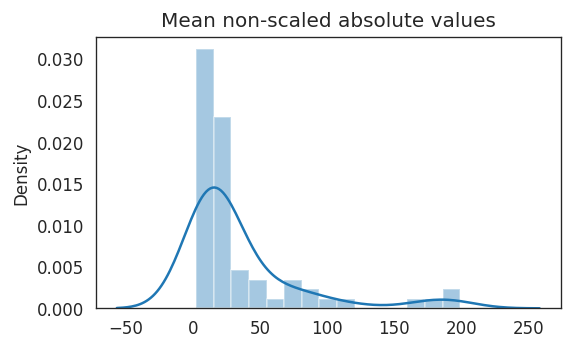

In [2]:
fc = read_dataset('/uftp/users/ashchetsova/hackathon/ID_vs_population_n_cells.tsv')
fc_old = read_dataset('/uftp/users/ashchetsova/hackathon/data_90_day.tsv')
fc = fc.reindex(fc_old.index)

anno = read_dataset('/uftp/users/ashchetsova/hackathon/total_annotation.tsv')
anno.index = anno.Sample_ID
anno = anno[['ID','cGVHD_development_time', 'cGVHD_development', 'Days','Day_after_transplant']]
anno = anno[~anno.index.duplicated()]
durations = pd.concat([anno[anno.cGVHD_development_time.isna()].ID.map(lambda x:anno[anno.ID==x].Day_after_transplant.max()),anno[~anno.cGVHD_development_time.isna()].cGVHD_development_time
                      ])
events = fc_old.GVHD_status
durations = durations.reindex(events.index)

fig,ax=plt.subplots(figsize=(5,3))
sns.distplot(fc.T.mean(),ax=ax)
plt.title('Mean non-scaled absolute values')


Text(0.5, 1.0, 'Mean log-scaled absolute values')

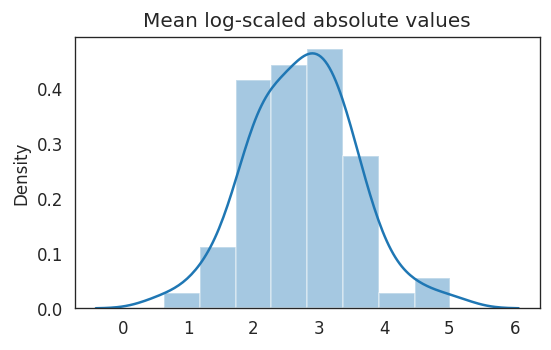

In [3]:
fc = np.log2(fc+1)
fig,ax=plt.subplots(figsize=(5,3))
sns.distplot(fc.T.mean(),ax=ax)
plt.title('Mean log-scaled absolute values')


In [4]:
parent_to_daughter = {i.split(' ')[0]:i for i in fc.columns}
fc_ranked = fc.T.rank().T
for key in parent_to_daughter.keys():
    cols = fc.columns[fc.columns.str.contains(key)]
    print(key,'\tlen\t',len(cols),'mean\t',fc_ranked[cols].T.mean().mean(),'std\t',fc_ranked[cols].T.mean().std())
    parent_to_daughter[key] = fc_ranked[cols].T.mean()
parent_to_daughter = pd.DataFrame(parent_to_daughter)
parent_to_daughter['CD4_to_CD8'] = parent_to_daughter['CD4+']/parent_to_daughter['CD8+']
parent_to_daughter['Th'] = parent_to_daughter[['Th17',	'Th1','Th22','Th17.1','Tfh']].T.mean()
parent_to_daughter['Treg_to_Th'] = parent_to_daughter['Treg']/parent_to_daughter['Th']

CD8+ 	len	 52 mean	 87.37587412587412 std	 11.376954448937838
CD4+ 	len	 52 mean	 92.7972027972028 std	 7.8164979942816055
Treg 	len	 19 mean	 59.950558213716114 std	 14.845026929214987
Treg_Th22 	len	 1 mean	 47.871212121212125 std	 18.5618116253735
Treg_Th2 	len	 2 mean	 49.14772727272727 std	 15.685673109850622
Treg_Th17.1 	len	 1 mean	 12.5 std	 7.767288409140556
Treg_Th17 	len	 2 mean	 37.484848484848484 std	 10.664812630244773
Treg_Th1 	len	 3 mean	 31.335858585858592 std	 9.868991948117198
Th22 	len	 7 mean	 31.945887445887447 std	 8.732138626539442
Th2 	len	 14 mean	 42.83008658008657 std	 7.405058574276365
Th17.1 	len	 7 mean	 27.023809523809522 std	 9.514884096067108
Th17 	len	 14 mean	 40.05844155844156 std	 6.672619244418973
Th1 	len	 21 mean	 43.7435064935065 std	 6.787488098542187
Tfh 	len	 1 mean	 101.00757575757575 std	 19.046197364110085


In [5]:
# it's important to set Random seed to make results reproducible. choose your lucky number
SEED = 42
np.random.seed(SEED)
# if you want to limit the number of parallel threads, 
# which is especially important when working on biomics and galactomics, set the number here. 
# the default is using all threads availiable (for quber)
n_jobs = -1
#n_jobs = 0 #default for the server's system settings 

# Baseline

In [8]:
from pycaret.classification import *
exp = ClassificationExperiment()

In [41]:
data = pd.concat([fc[['CD4+ NV maturity and HLA-DR+ expression', 'CD4+ NV maturity and PD-1+TIGIT+ expression', 'CD4+ NV maturity and PD1+ expression', 'CD4+ None maturity and None expression', 'CD4+ CM maturity and CD226+ expression', 'CD8+ EM maturity and None expression', 'CD4+ CM maturity and PD-1+TIGIT- expression', 'CD4+ NV maturity and PD-1+TIGIT- expression', 'CD4+ CM maturity and None expression', 'CD4+ NV maturity and TIGIT+ expression', 'Th22 CM maturity and None expression', 'CD8+ EMTM maturity and PD-1+TIGIT+ expression']], events],axis=1)
data.columns = data.columns.to_list()[:-1]+['GVHD_Development']

In [42]:
exp.setup(data, target = 'GVHD_Development', session_id = SEED,preprocess=False,log_experiment = False,n_jobs=-1,train_size=0.75, log_plots=True, fold=5,feature_selection=True,feature_selection_method='sequential',remove_multicollinearity = True, multicollinearity_threshold = 0.7,    remove_outliers= True,  outliers_method = 'iforest',    outliers_threshold = 0.05)

,Description,Value
0,Session id,42
1,Target,GVHD_Development
2,Target type,Binary
3,Original data shape,"(66, 13)"
4,Transformed data shape,"(66, 13)"
5,Transformed train set shape,"(49, 13)"
6,Transformed test set shape,"(17, 13)"
7,Numeric features,12


In [43]:
best = exp.compare_models(fold=3,probability_threshold=0.5, n_select=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7525,0.8045,0.7063,0.7321,0.7063,0.4948,0.5087,0.1700
knn,K Neighbors Classifier,0.7145,0.7304,0.6190,0.7500,0.6116,0.3983,0.4457,0.5467
xgboost,Extreme Gradient Boosting,0.7120,0.8063,0.7063,0.6528,0.6723,0.4176,0.4250,0.2633
catboost,CatBoost Classifier,0.7120,0.7738,0.6111,0.7083,0.6344,0.4025,0.4257,0.6167
lda,Linear Discriminant Analysis,0.6532,0.6519,0.6508,0.5741,0.6083,0.2977,0.3008,0.0200
svm,SVM - Linear Kernel,0.6520,0.0000,0.2857,0.5238,0.3386,0.1860,0.2248,0.0200
gbc,Gradient Boosting Classifier,0.6311,0.6989,0.5556,0.5833,0.5501,0.2420,0.2551,0.0500
et,Extra Trees Classifier,0.6311,0.7272,0.5079,0.5833,0.5261,0.2326,0.2457,0.1500
nb,Naive Bayes,0.6299,0.7325,0.6111,0.5563,0.5554,0.2603,0.2769,0.0233
dt,Decision Tree Classifier,0.6299,0.6204,0.5556,0.6481,0.5556,0.2484,0.2806,0.0200


In [68]:
X = fc.copy()[features]
y = events

In [69]:
X_discovery, X_val, y_discovery, y_val = train_test_split(X, y, test_size=0.6, random_state=SEED, stratify=y)

In [70]:
# here, I only take the "train" chunk of discovery data
feature_selector = BorutaShap(importance_measure='shap', classification=False)
feature_selector.fit(X=X_discovery, y=y_discovery, n_trials=5000, random_state=SEED, train_or_test='train',
                        normalize=True,
                     verbose=True)
selected_features = [i for i in X.columns if i not in feature_selector.features_to_remove]
print(selected_features)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [97]:
import shap
shap.initjs()
import optuna.integration.xgboost as xgb
import lightgbm
import xgboost
import sklearn.metrics
from sklearn.model_selection import train_test_split
import optuna
from BorutaShap import BorutaShap, load_data
from xgbse.metrics import concordance_index


In [98]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    print('matches: ', matches,' total: ', total)
    return matches/total

def prepare_survival(row):
    if row['OS_FLAG'] == 0:
        return -1 * row['OS']
    return row['OS']
    
def prepare_bounds(row):
    if row['OS_FLAG'] == 0:
        return [row['OS'], np.inf]
    else:
        return [0, row['OS']]

In [37]:
features = ['CD4+ NV maturity and HLA-DR+ expression', 'CD4+ NV maturity and PD-1+TIGIT+ expression', 'CD4+ NV maturity and PD1+ expression', 'CD4+ None maturity and None expression', 'CD4+ CM maturity and CD226+ expression', 'CD8+ EM maturity and None expression', 'CD4+ CM maturity and PD-1+TIGIT- expression', 'CD4+ NV maturity and PD-1+TIGIT- expression', 'CD4+ CM maturity and None expression', 'CD4+ NV maturity and TIGIT+ expression', 'Th22 CM maturity and None expression', 'CD8+ EMTM maturity and PD-1+TIGIT+ expression']

In [96]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


def objective(trial):
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 80, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }
    model = xgb.XGBClassifier(random_state=SEED, n_jobs=n_jobs, **param)
    
    X_train, X_test, y_train, y_test = train_test_split(X_discovery, y_discovery, test_size=0.2, random_state=SEED)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-08-12 13:56:45,906] A new study created in memory with name: no-name-24921a64-9d9b-4261-a6a2-d9d3452d0ee9
[I 2023-08-12 13:56:46,055] Trial 0 finished with value: 0.3333333333333333 and parameters: {'booster': 'gbtree', 'learning_rate': 0.16918341761536962, 'n_estimators': 93, 'max_depth': 10, 'min_child_weight': 2.699041783370335, 'subsample': 0.7497883787462913, 'colsample_bytree': 0.659824951717764, 'colsample_bylevel': 0.6015323892608389, 'gamma': 0.05343637312564936, 'reg_alpha': 0.9845436384520485, 'reg_lambda': 0.26498129930178826}. Best is trial 0 with value: 0.3333333333333333.
[I 2023-08-12 13:56:46,180] Trial 1 finished with value: 0.3333333333333333 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1342554146411344, 'n_estimators': 81, 'max_depth': 4, 'min_child_weight': 2.8874250965183412, 'subsample': 0.9556285204065353, 'colsample_bytree': 0.6754517821879847, 'colsample_bylevel': 0.7129336907214465, 'gamma': 0.3299031339423522, 'reg_alpha': 0.8416286875153

In [83]:
study.best_params

{'booster': 'gblinear',
 'learning_rate': 0.0715559596102712,
 'n_estimators': 94,
 'max_depth': 5,
 'min_child_weight': 4.891009166379371,
 'subsample': 0.8750588706212519,
 'colsample_bytree': 0.7386371120688078,
 'colsample_bylevel': 0.7492967578298728,
 'gamma': 0.12511841166144674,
 'reg_alpha': 0.24493238214913976,
 'reg_lambda': 0.290664497662243}

In [84]:
model = xgb.XGBClassifier(random_state=SEED, n_jobs=n_jobs, **study.best_params)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_discovery, y_discovery, stratify=y_discovery, test_size=0.15, random_state=SEED)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],early_stopping_rounds=round(study.best_params['n_estimators']), verbose=True)

[13:54:41] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67818	validation_1-logloss:0.68262
[1]	validation_0-logloss:0.66732	validation_1-logloss:0.67590
[2]	validation_0-logloss:0.65929	validation_1-logloss:0.67165
[3]	validation_0-logloss:0.65317	validation_1-logloss:0.66903
[4]	validation_0-logloss:0.64815	validation_1-logloss:0.66762
[5]	validation_0-logloss:0.64355	validation_1-logloss:0.66688
[6]	validation_0-logloss:0.63934	validation_1-logloss:0.66653
[7]	validation_0-logloss:0.63530	validation_1-logloss:0.66640
[8]	validation_0-logloss:0.63149	validation_1-logloss:0.66640

XGBClassifier(base_score=0.5, booster='gblinear', callbacks=None,
              colsample_bylevel=0.7492967578298728, colsample_bynode=None,
              colsample_bytree=0.7386371120688078, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.12511841166144674, gpu_id=-1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0715559596102712, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=4.891009166379371, missing=nan,
              monotone_constraints=None, n_estimators=94, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic',
              predictor=None, random_state=42, reg_alpha=0.24493238214913976, ...)

In [89]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
sns.set_style('white')
shap.summary_plot(shap_values[1], X,max_display=20, plot_type='dot')

AssertionError: Only the 'gbtree' model type is supported, not 'gblinear'!

<AxesSubplot:>

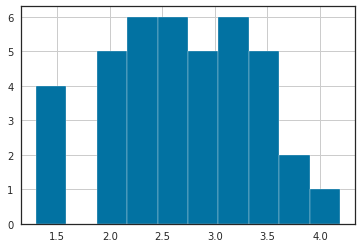

In [95]:
X_val.T.mean().hist()

In [91]:
# estimation is always with kfolds
cv = KFold(n_splits=3)
name = 'GVHD_prediction'
metrics_array = {}
X_estim = X_val
y_estim = y_val
thr = 0.5
for i, (train, test) in enumerate(cv.split(X_estim, y_estim)):
    X_fold_test, y_fold_test = X_estim.iloc[test],y_estim.iloc[test]
    metrics_array[i] = calculate_metrics(model,X_fold_test, y_fold_test,verbose=False,ret=True,
                                plot_curves=False, plot_correlations=False,plot_confusion_matrices=False,classifier= True,
                               name = f"{name}_{i}",thr=thr)


metrics_array = pd.DataFrame(metrics_array).T


Text(0.5, 0.98, 'RF model predicting GVHD development (90 days)')

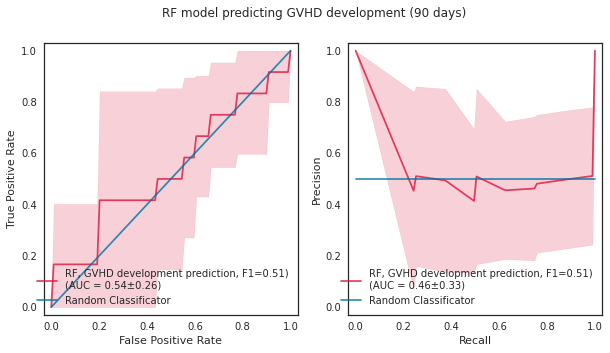

In [93]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
plt_mean_auc_curve(axes[0],[arr[~np.isnan(arr)] for arr in metrics_array.fpr.to_list() if len(arr[~np.isnan(arr)])>0],
                   [arr[~np.isnan(arr)] for arr in metrics_array.tpr.to_list() if len(arr[~np.isnan(arr)])>0],
                   [arr[~np.isnan(arr)] for arr in metrics_array.ROC_AUC.to_list() if len(arr[~np.isnan(arr)])>0],name=name,type='roc'
              )
plt_mean_auc_curve(axes[1],metrics_array.recall.to_list(),
                   metrics_array.precision.to_list(),
                   metrics_array.PR_AUC.to_list(),name=name,type='pr'
              )
n = round(len(y_estim),2)
name = f'RF model predicting GVHD development (90 days)'

fig.suptitle(name)

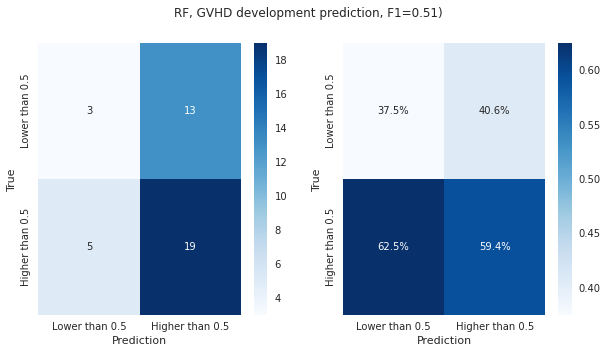

In [92]:
from sklearn.metrics import f1_score
# categorization
y_test_bin = pd.concat(metrics_array.y_test_bin.to_list())
y_pred_bin = pd.concat(metrics_array.y_pred_bin.to_list())

f1 = round(f1_score(y_test_bin,y_pred_bin, average='weighted'),2)
name = f'RF, GVHD development prediction, F1={f1})'
# confusion matrix
plt_confusion_matrix(y_test_bin,y_pred_bin,thr=thr,name=name)
